In [59]:
import numpy as np
import pandas as pd
import tensorly as tl

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

import sys
import os
import pickle

import brainconn

sys.path.append("./CLRIA")
import clria

## Data loading

* HCP data: Structural connectivity (SC) was inferred from minimally preprocessed, high-resolution diffusion-weighted MRI data from healthy young adults participating in the Human Connectome Project. The human Brainnetome atlas divides the cortex and subcortex into 246 regions. The group-representative connectivity matrix was computed using a consensus method that combined individual-level networks while preserving the average connection density across subjects.

In [6]:
SC = pickle.load( open("./data/SC_group_thr10.pkl", "rb") )
SC.shape

(246, 246)

* AHBA data: Human brain gene expression from AHBA (http://human.brain-map.org) was measured in six post-mortem brains, containing 3702 spatially distinct samples and 58692 probes. After processing using `abagen`, we got a expression matrix of 123 regions (__left hemisphere__) and 15634 genes. 

In [4]:
expr = pd.read_parquet("./data/bna246_left_exprs.parq")
expr.shape

(123, 15634)

## Data preprocessing

* process SC: construct the communication measure using strage from routing to diffusion. For more details, see https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006833

In [22]:
bncm_obj = clria.otpp.BNCM()
DD = bncm_obj.proximal_to_distance(SC)                ## strength-to distance mapping
SPL = brainconn.distance.distance_wei_floyd(DD)[0]    ## shortest path length

if not os.path.exists("./data/CM_thr10.pkl"):
    lambda_vals = np.concatenate([[0], np.logspace(1.6, -3.0, 30)[::-1]])
    lambda_M = []
    for lambda_ in lambda_vals:
        lambda_M.append( bncm_obj.calc_TransCost(DD, SPL, lambda_=lambda_) )
    
    with open( f"./data/CM_thr10.pkl", "wb" ) as out:
        pickle.dump( [np.array(lambda_M).transpose(1, 2, 0), lambda_vals ] )

lambda_spectrum = pickle.load( open("./data/CM_thr10.pkl", "rb") )
lambda_spectrum[0].shape, lambda_spectrum[1].shape

((246, 246, 31), (31,))

* process expr: extract expression matrix and coupling matrix

In [24]:
expr = pd.read_parquet("./data/bna246_left_exprs.parq")
lrdb_obj = clria.otpp.LRdatabase(level="lr")
lrdb_obj.extract_lr_expression(expr, method="geo")   ## extract expression matrix of ligand and receptor
lrdb_obj.generate_coupling_matrix()                  ## generate coupling matrix of ligand and receptor
print(lrdb_obj.L.shape, lrdb_obj.R.shape, lrdb_obj.TL.shape, lrdb_obj.TR.shape)

(123, 244) (123, 317) (1242, 244) (1242, 317)


## Communication strategy preference

* CLRIA distance is the Frobenius inner product between the communication model (M) and $A{\rm diag}(C^T 1) B^T$. 
* By substituting $M$ by a different communication strategy, we can quantify the energy cost for transporting ligands to receptors using the CLRIA distance.
* For practical usage, a spatial-preserving null model were used.

In [ ]:
lambda_M, lambda_vals = lambda_spectrum[0][:, :, 1:], lambda_spectrum[1][1:]
L, R, TL, TR = lrdb_obj.L.values, lrdb_obj.R.values, lrdb_obj.TL.values, lrdb_obj.TR.values

* calculate empirical CLRIA distance

In [ ]:
## calculate empirical CLRIA distance
out_filename = f"./data/CLRIA_distance.pkl"
if not os.path.exists(out_filename):
    CLRIA_distance = {}
    scale_factor = 1e4
    for i, use_val in enumerate(lambda_vals):

        ## Norm with equal sum
        mtx = lambda_M[:, :, i]
        M = mtx[::2, :][:, ::2]        ## select left hemisphere
        M = M/M.sum() * scale_factor

        res_tmp = {"normM":M.copy()}
        mmot = clria.ottl.MMOTNTD(L, R, M, TL, TR)
        for r in [5, 10, 20, 30]:
            ## MMOTNTF: update
            print("Params:", i, use_val, r, sep="\t", end="\n")
            mmot.fit(r=r, max_iter=20000, stopThr=[1e-8, 1e-3])
            (Ae, Be, Ce) = mmot.factors
            res_tmp[r] = [(Ae, Be, Ce), mmot.calc_obj_res(Ae, Be, Ce)]
        CLRIA_distance[use_val] = res_tmp.copy()
        pickle.dump(CLRIA_distance, file=open(out_filename, "wb"))
        #break

* calculate null model

In [ ]:
## calculate null model
surf_files = ( "./data/spin_test/lh.BN_atlas.annot", "./data/spin_test/rh.BN_atlas.annot")
info = pd.read_csv("./data/spin_test/BNA_info_Yeo.csv")
perm_idx = clria.ottl.gen_permM(surf_files, info, n_perm=100) # N_region * n_perm

out_filename = f"./data/CLRIA_distance_perm.pkl"
if not os.path.exists(out_filename):
    CLRIA_distance_perm = {}
    scale_factor = 1e4
    for i, use_val in enumerate(lambda_vals):
        ## Norm with equal sum
        mtx = lambda_spectrum[0][:, :, i]
        M = mtx[::2, :][:, ::2] ## left hemisphere
        M = M/M.sum() * scale_factor
        
        Mperm = M.copy()
        res_tmp = {}
        for r in [5, 10, 20, 30]:
            print("Params:", i, use_val, r, "res:", sep="\t", end="\n")

            ## permutation
            perm_res = []
            for idx_perm in range(perm_idx.shape[1]):
                use_idx = perm_idx[:, idx_perm]
                Mperm = M[use_idx, :][:, use_idx]

                mmotperm = clria.ottl.MMOTNTD(L, R, Mperm, TL, TR)
                mmotperm.fit(r=r, max_iter=20000, stopThr=[1e-8, 1e-3], )  ## sequential, random
                (Aperm, Bperm, Cperm) = mmotperm.factors
                all_pairs = mmotperm.calc_obj_res(Aperm, Bperm, Cperm)                                     ## all LR pairs
                each_pair = [ (tl.matmul(Ae*Ce[[k], :], Be.T) * Mperm).sum() for k in range(Ce.shape[0])]  ## each LR pair
                perm_res.append( [all_pairs, each_pair] )
                #break
            res_tmp[r] = perm_res.copy()
            #break
        CLRIA_distance_perm[use_val] = res_tmp.copy()
        pickle.dump(CLRIA_distance_perm, file=open(out_filename, "wb"))
        #break

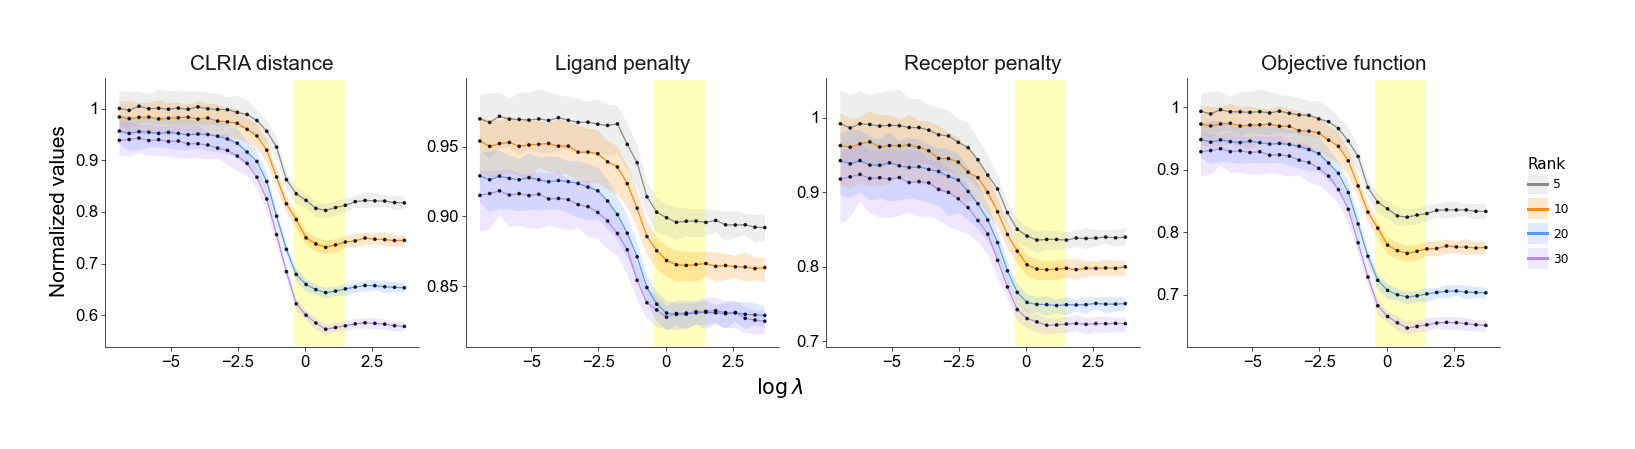

<ggplot: (8784671086400)>

In [40]:
res_normM = pickle.load( open(f"./data/CLRIA_distance.pkl", "rb") )
res_permM = pickle.load( open(f"./data/CLRIA_distance_perm.pkl", "rb") )

n_perm = 100
use_idx = [0, 2, 3, 4]
use_name = np.array(["CLRIA distance", "Ligand penalty", "Receptor penalty", "Objective function"])

dat_line = []
for n, key in enumerate(CLRIA_distance):
    for rank in [5, 10, 20, 30]:
        empi_obj = np.array(  res_normM[key][rank][-1])
        perm_obj = np.array([ res_permM[key][rank][n][0] for n in range(n_perm) ])
        empi_obj = empi_obj[use_idx]
        perm_obj = perm_obj[:, use_idx]
        
        tmp = tmp = empi_obj / perm_obj
        avg, std = tmp.mean(axis=0), tmp.std(axis=0, ddof=1)
        low, high = a, b = np.quantile(tmp, q=[0.025, 0.975], axis=0)
        for k, name in enumerate(use_name):
            dat_line.append([key, rank, name, avg[k], std[k], low[k], high[k]])

dat_line = pd.DataFrame(dat_line)
dat_line.columns = ["lamda", "Rank", "Type", "mean", "std", "low1", "high1"]
dat_line["lamda"] = np.log(dat_line["lamda"])
dat_line["Rank"] = pd.Categorical(dat_line["Rank"], categories=[5, 10, 20, 30])
dat_line["Type"] = pd.Categorical(dat_line["Type"], categories=use_name)

line_plot =(
    p9.ggplot(data=dat_line, mapping=p9.aes(x="lamda", y="mean"))
    + p9.geom_rect(xmin=-0.5, xmax=1.5, ymin=-np.Inf, ymax=np.Inf, fill="#FFFFBB", alpha=0.01, color="white")
    + p9.geom_ribbon(p9.aes(ymin="low1", ymax="high1", fill="Rank", group="Rank"), alpha=0.2)
    + p9.geom_line(mapping=p9.aes(color="Rank", group="Rank"), size=0.5)
    
    + p9.geom_point(mapping=p9.aes(group="Rank"), size=0.5, color="black", alpha=0.8)
    + p9.scale_color_manual(values=["#888888", "#FF8800", "#5599FF", "#B088FF",  ])
    + p9.scale_fill_manual(values=["#AAAAAA",  "#FF8800", "#5599FF", "#B088FF",  ])
    + p9.xlab("$\log \lambda$")
    + p9.ylab("Normalized values")
    + p9.theme_classic()
    + p9.theme(
        axis_ticks_minor = p9.element_blank(),
        axis_text=p9.element_text(size=12, color="black", family="Arial"),
        axis_title=p9.element_text(size=15, color="black", family="Arial"),
        axis_line=p9.element_line(color="black", size=0.5),
        axis_ticks=p9.element_line(color="black", size=0.5),

        strip_background=p9.element_blank(),
        strip_text=p9.element_text(size=15, family="Arial"),
        subplots_adjust={"hsapce":0.5, "wspace":0.15},
        figure_size=(18, 3.5)
    )
    + p9.facet_wrap("~Type", nrow=1, ncol=5, scales="free")
)
line_plot

## Network exploration

In [49]:
## load atlas information
atlas_info = pd.read_csv("./data/BN_info_Yeo_hierarchy.csv")
atlas_left = atlas_info.loc[atlas_info["hemisphere"]=="L", :].reset_index(drop=True)
use_term = ["Myelin", "FC", "SAaxis"]

## load tensor factor matrix
n_lambda, rank, = 20, 20
res_normM = pickle.load( open(f"./data/CLRIA_distance.pkl", "rb") )
lambda_vals = list(res_normM.keys())
Ae, Be, Ce = res_normM[lambda_vals[n_lambda]][rank][0]

* communication patterns

In [50]:
tca_obj = clria.ottl.TCA(Ae, Be, Ce)
for name in ["Lobe", "Gyrus_abbr", "Yeo_net7_name", "Yeo_net17_sub"]:
    clria.otpl.plot_sankey(tca_obj, atlas_left[[name]])

* LR-specific communication network

In [52]:
tca_obj = clria.ottl.TCA(Ae, Be, Ce, lrdb_obj=lrdb_obj)
dopa_net, dopa_name = tca_obj.get_pathway_network(pathway_name="Dopamine", return_LR_name=True)
dopa_name

array(['SLC18A2_DDC|DRD1', 'SLC18A2_DDC|DRD2', 'SLC18A2_DDC|DRD4',
       'SLC6A3_DDC|DRD1', 'SLC6A3_DDC|DRD2', 'SLC6A3_DDC|DRD4'],
      dtype=object)

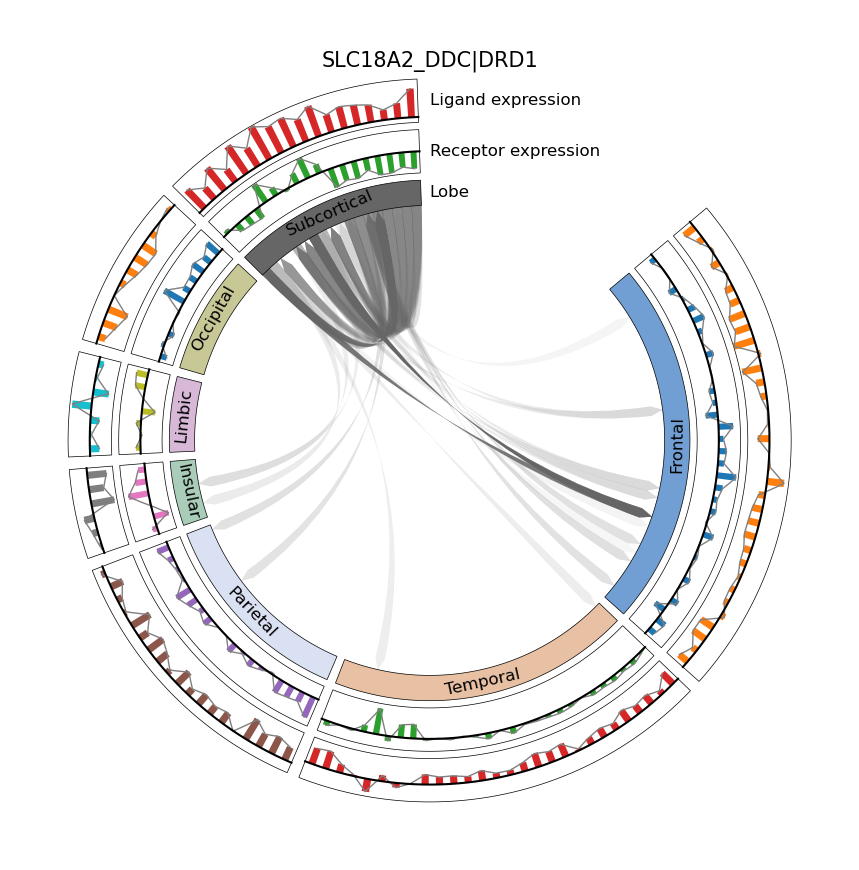

In [56]:
strength_thr = 0.05
source_lobe = ["Subcortical"]
plt.close()
clria.otpl.plot_circos(tca_obj, atlas_left.copy(), 'SLC18A2_DDC|DRD1', True,
                 strength_thr=strength_thr, source_lobe = source_lobe, is_show=True)
plt.show()

## Asymmetric signaling

In [43]:
## load atlas information
atlas_info = pd.read_csv("./data/BN_info_Yeo_hierarchy.csv")
atlas_left = atlas_info.loc[atlas_info["hemisphere"]=="L", :].reset_index(drop=True)
use_term = ["Myelin", "FC", "SAaxis"]

## load tensor factor matrix
n_lambda, rank, = 20, 20
res_normM = pickle.load( open(f"./data/CLRIA_distance.pkl", "rb") )
lambda_vals = list(res_normM.keys())
Ae, Be, Ce = res_normM[lambda_vals[n_lambda]][rank][0]

## prepare TCA object
tca_obj = clria.ottl.TCA(Ae, Be, Ce)
tca_obj.calc_T_statistics_matrix()

* trans-hierarchical asymmetric signaling across cortical regions

In [44]:
## trans-hierarchical asymmetric signaling across cortical regions
res = {}
for term in use_term:
    hierarchy = atlas_left[term].values
    order = "descending" if term == "Myelin" else "ascending"
    a, b, ks = tca_obj.analyze_trans_hierarchical_signaling_cortex(hierarchy, order=order)
    res[term] = [a, b, ks]

* asymmetric signaling across between cortical and subcortical regions

In [46]:
## asymmetric signaling across between cortical and subcortical regions
h1 = (atlas_left["structure"]=="subcortex").values
h2 = (atlas_left["structure"]=="cortex").values
res2 = tca_obj.analyze_trans_hierarchical_signaling_cortex_and_subcortex(hierarchy=(h1, h2))

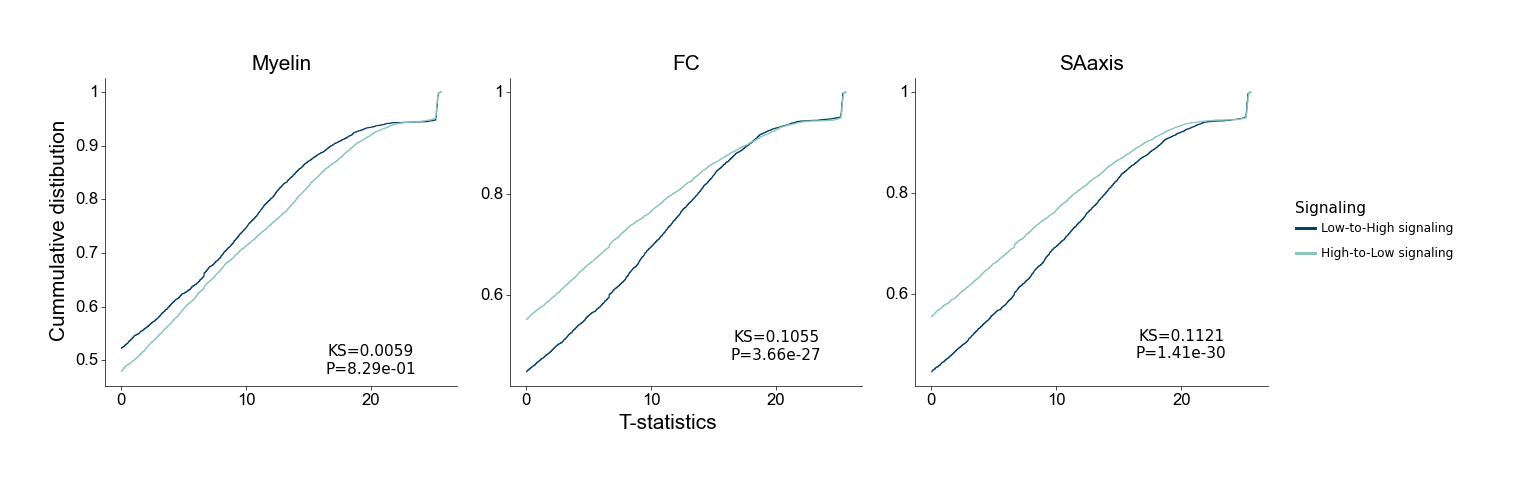

<ggplot: (8784651915749)>

In [47]:
from statsmodels.stats import multitest

cdf_dat = []
ks_dat = []
for term in res:
    l2h, h2l, ks = res[term]
    
    l2h = pd.DataFrame(l2h, columns=["Value"])
    l2h["Tag"] = term
    l2h["Signaling"] = "Low-to-High signaling"
    
    h2l = pd.DataFrame(h2l, columns=["Value"])
    h2l["Tag"] = term
    h2l["Signaling"] = "High-to-Low signaling"

    cdf_dat.append(pd.concat([l2h, h2l]))
    ks_dat.append([term, ks[0], ks[1]])

cdf_dat2 = pd.concat(cdf_dat)
cdf_dat2["Tag"] = pd.Categorical(cdf_dat2["Tag"], categories=["Myelin", "FC", "SAaxis"])
cdf_dat2["Signaling"] = pd.Categorical(cdf_dat2["Signaling"], 
                                       categories=["Low-to-High signaling", "High-to-Low signaling"])
ks_dat2 = pd.DataFrame(ks_dat)
ks_dat2.columns = ["Tag", "KS", "Pvalue"]
ks_dat2["Tag"] = pd.Categorical(ks_dat2["Tag"], categories=["Myelin", "FC", "SAaxis"])
ks_dat2["FDR"] = multitest.fdrcorrection(ks_dat2["Pvalue"].values)[1]
ks_dat2["Label"] = [ f"KS={ks:.4f}\nP={fdr:.2e}" for ks, fdr in zip(ks_dat2["KS"].values, ks_dat2["Pvalue"].values) ]

cdf_plot = (
    p9.ggplot(data=cdf_dat2)
    + p9.stat_ecdf(mapping=p9.aes(x="Value", color="Signaling"),)
    + p9.geom_text(mapping=p9.aes(x=20, y=0.5, label="Label"), data=ks_dat2)
    + p9.ylab("Cummulative distibution")
    + p9.xlab("T-statistics")
    + p9.scale_color_manual(values=["#074166", "#8CC5BE"])
    + p9.theme_classic()
    + p9.theme(
        axis_ticks_minor = p9.element_blank(),

        axis_text=p9.element_text(size=12, color="black", family="Arial"),
        axis_text_x=p9.element_text(rotation=0),
        axis_title=p9.element_text(size=15, color="black", family="Arial"),
        axis_line=p9.element_line(color="black", size=0.5),
        axis_ticks=p9.element_line(color="black", size=0.5),

        #strip_background=p9.element_rect(size=0.5),
        strip_background=p9.element_blank(),
        
        strip_text=p9.element_text(size=15, family="Arial", color="black"),
        subplots_adjust={"hspace":0.3, "wspace":0.15},
        figure_size=(15, 4)
    )
    #+ p9.facets()
    + p9.facet_wrap("~Tag", nrow=1, ncol=3, scales="free")
)
cdf_plot

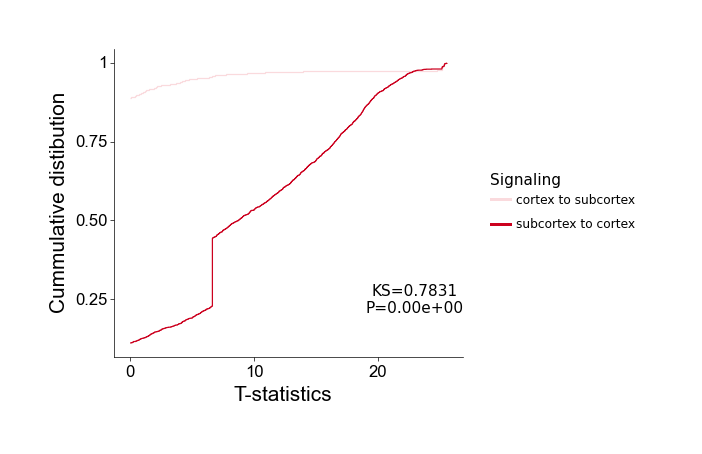

<ggplot: (8784645264857)>

In [48]:
cdf_dat = []
ks_dat = []

l2h, h2l, ks = res2

l2h = pd.DataFrame(l2h, columns=["Value"])
l2h["Tag"] = term
l2h["Signaling"] = "subcortex to cortex"

h2l = pd.DataFrame(h2l, columns=["Value"])
h2l["Tag"] = term
h2l["Signaling"] = "cortex to subcortex"

cdf_dat.append(pd.concat([l2h, h2l]))
ks_dat.append([term, ks[0], ks[1]])

cdf_dat2 = pd.concat(cdf_dat)
cdf_dat2["Tag"] = pd.Categorical(cdf_dat2["Tag"], categories=["Myelin", "FC", "SAaxis"])
cdf_dat2["Signaling"] = pd.Categorical(cdf_dat2["Signaling"], 
                                       categories=["cortex to subcortex", "subcortex to cortex"])
ks_dat2 = pd.DataFrame(ks_dat)
ks_dat2.columns = ["Tag", "KS", "Pvalue"]
ks_dat2["Tag"] = pd.Categorical(ks_dat2["Tag"], categories=["Myelin", "FC", "SAaxis"])
ks_dat2["FDR"] = multitest.fdrcorrection(ks_dat2["Pvalue"].values)[1]
ks_dat2["Label"] = [ f"KS={ks:.4f}\nP={fdr:.2e}" for ks, fdr in zip(ks_dat2["KS"].values, ks_dat2["Pvalue"].values) ]

cdf_plot = (
    p9.ggplot(data=cdf_dat2)
    + p9.stat_ecdf(mapping=p9.aes(x="Value", color="Signaling"),)
    + p9.geom_text(mapping=p9.aes(x=23, y=0.25, label="Label"), data=ks_dat2)
    + p9.ylab("Cummulative distibution")
    + p9.xlab("T-statistics")
    + p9.scale_color_manual(values=["#FADADD", "#CC011F"])
    + p9.theme_classic()
    + p9.theme(
        axis_ticks_minor = p9.element_blank(),

        axis_text=p9.element_text(size=12, color="black", family="Arial"),
        axis_text_x=p9.element_text(rotation=0),
        axis_title=p9.element_text(size=15, color="black", family="Arial"),
        axis_line=p9.element_line(color="black", size=0.5),
        axis_ticks=p9.element_line(color="black", size=0.5),

        #strip_background=p9.element_rect(size=0.5),
        strip_background=p9.element_blank(),
        
        strip_text=p9.element_text(size=15, family="Arial", color="black"),
        subplots_adjust={"hspace":0.3, "wspace":0.15},
        figure_size=(4.5, 4)
    )
    #+ p9.facets()
    #+ p9.facet_wrap("~Tag", nrow=1, ncol=3, scales="free")
)
cdf_plot

* graph spectrum analysis

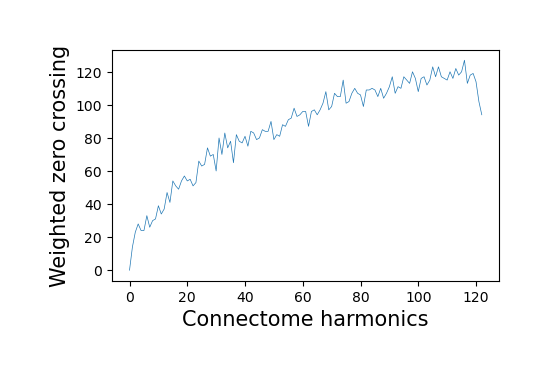

In [58]:
SC = pickle.load( open("./data/SC_group_thr10.pkl", "rb") )
SC_left = SC[::2, :][:, ::2]
lambdaL, U = clria.ottl.SC_L_decomposition(SC_left)

## Compute weighted zero crossings
wZC = []
for u in range(U.shape[1]):
    UU = U[:, u]
    summ = 0
    for i in range(len(UU)-1):
        for j in range(i+1, len(UU)):
            if UU[i]*UU[j] < 0:
                summ += (SC_left[i, j] > 1)
    wZC.append(summ)

plt.figure(figsize=(5, 3))
plt.plot(wZC)
plt.xlabel("Connectome harmonics", size=15)
plt.ylabel("Weighted zero crossing", size=15)
plt.show()
plt.close()

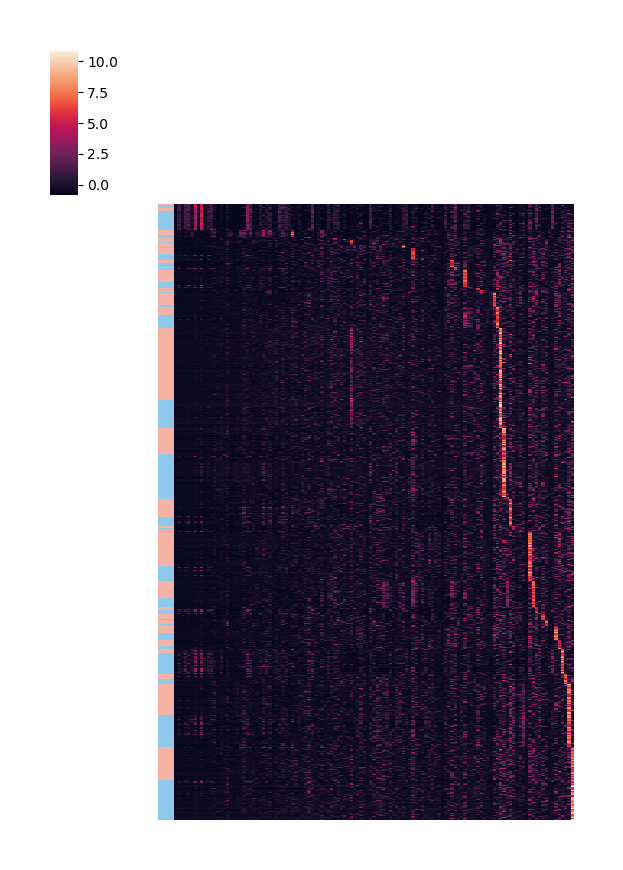

In [62]:
tca_obj = clria.ottl.TCA(Ae, Be, Ce, lrdb_obj=lrdb_obj)
hamonics = U.copy()
lr_psd = tca_obj.graph_spectrurm_analysis(hamonics=hamonics)

## row z-score for visualization
lr_psd_zscore = lr_psd.copy()
mean = lr_psd_zscore.mean(axis=1, keepdims=True)
std = lr_psd_zscore.std(axis=1, ddof=1, keepdims=True)
lr_psd_zscore = (lr_psd_zscore-mean)/std

## ordering LR pair according to theie type and dominent hamonics
idx = lr_psd_zscore.argmax(axis=1)
is_neurontransmitter = tca_obj.lr_anno["is_neurontransmitter"].values.copy()
sort_vals = np.concatenate([idx.reshape(-1, 1), 1-is_neurontransmitter.astype(int).reshape(-1, 1)], axis=1)
idx = pd.DataFrame(sort_vals).sort_values(by=[0, 1]).index.values

lr_psd_zscore = lr_psd_zscore[idx, :]
is_neurontransmitter = is_neurontransmitter[idx]

plt.close()
sns.clustermap( lr_psd_zscore, col_cluster=False, row_cluster=False, #cmap="RdBu_r",
               figsize=(5.5, 8),
               row_colors=np.array(["#8EC8ED", "#F5B3A5"])[is_neurontransmitter.astype(int)],
               **{"xticklabels":False, "yticklabels":False}
               )
plt.show()
plt.close()

## brain state transition

* Here, brain states were defined as spatial pattern estimates associated with activity across the brain regions of interest during the working memory condition (2-back) and the attention control condition (0-back).
* There are other way to define brain state such as:
    * binray vector of canonical intrinsic connectivity networks, 
    * binary vector of hierarical bins
    * based on neurosynth

In [ ]:
## load data
res_normM = pickle.load( open(f"./data/CLRIA_distance.pkl", "rb") )
lambda_vals = list(res_normM.keys())
n_lambda, rank = 20, 20
Ae, Be, Ce = res_normM[lambda_vals[n_lambda]][rank][0]

Asum0, Bsum0 = Ae.sum(axis=0, keepdims=True), Be.sum(axis=0, keepdims=True)
Ae /= Asum0
Be /= Bsum0
patternAB = [ np.outer(Ae[:, i], Be[:, i]) for i in range(Ae.shape[1]) ]

* UOT regression

In [ ]:
UOTR_obj = clria.ottl.UOTRegression(pattern=patternAB, regP=1, regm=1, lambda_=2)

path = "../../data/HCP_tfMRI/"
pkl_files = [ path+i for i in os.listdir(path) if i.endswith("_beta_0bk_2bk.pkl") ]

out_filename = "./data/04.mean_sigm_res_UOT_0bk_2bk.pkl"
if not os.path.exists(out_filename):
    res = []
    for pkl in pkl_files:
        subj_id = pkl.split("/")[-1].split("_")[0]
        #print(subj_id)

        ## 00. load data
        beta_0bk, beta_2bk = pickle.load( open(pkl, "rb") )

        ## 01. norm data
        beta_0bk = beta_0bk[::2]
        beta_0bk[beta_0bk<=0] = 1e-100
        beta_2bk = beta_2bk[::2]
        beta_2bk[beta_2bk<0] = 1e-100

        ## 0bk -> 2bk
        beta1, P1 = UOTR_obj.fit(src=beta_0bk, dst=beta_2bk, max_iter=[5000, 1000, 5000], delta=1e-12)
        beta1 /= beta1.sum()
        OTdist1 = UOTR_obj.get_opt_UOT_dist(beta1, P1)
        Obj1 = UOTR_obj.get_opt_obj_val(beta1, P1, beta_0bk, beta_2bk)

        ## 2bk -> 0bk
        beta2, P2 = UOTR_obj.fit(src=beta_2bk, dst=beta_0bk, max_iter=[5000, 1000, 5000], delta=1e-12)
        beta2 /= beta2.sum()
        OTdist2 = UOTR_obj.get_opt_UOT_dist(beta2, P2)
        Obj2 = UOTR_obj.get_opt_obj_val(beta2, P2, beta_2bk, beta_0bk)

        #print(subj_id, sep="\t")
        res.append([subj_id, OTdist1, OTdist2, Obj1, Obj2, beta1, beta2, OTdist1>OTdist2, Obj1>Obj2])

        #break
    pickle.dump(res, open("../res/04.mean_sigm_res_UOT_0bk_2bk.pkl", "wb") )

* transition difficulty

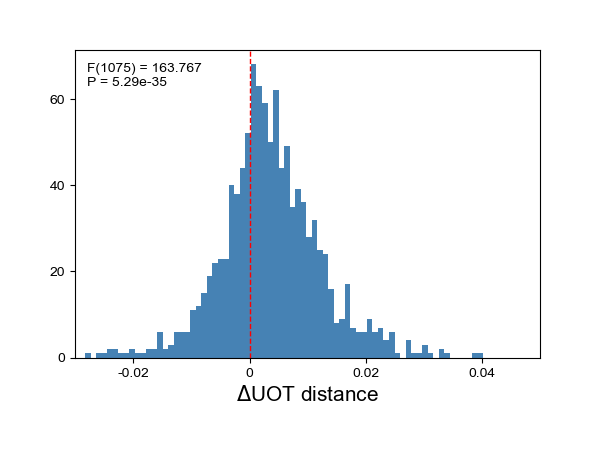

In [64]:
contrast_files = "./data/04.mean_sigm_res_UOT_0bk_2bk.pkl"
res = np.array([ tmp[1:3] for tmp in pickle.load( open(contrast_files, "rb") ) ])

tmp = res

plt.figure(figsize=(6, 4))
plt.hist( tmp[:, 0] - tmp[:, 1], bins=100, color="steelblue")
plt.xlim(-0.03, 0.05)
plt.ylim()
plt.axvline(x=0, linewidth=1, color="red", linestyle="dashed")
plt.xlabel("$\Delta$UOT distance", size=15, font="Arial")
plt.annotate(text=f"F(1075) = 163.767\nP = 5.29e-35", xy=(-0.028, 63), font="Arial") ## from ../../res/04.UOT_rm_ANOVA.tsv
plt.xticks(ticks=[-0.02, 0, 0.02, 0.04], labels=[-0.02, 0, 0.02, 0.04], font="Arial")
plt.yticks(ticks=[0, 20, 40, 60], labels=[0, 20, 40, 60], font="Arial")
#plt.savefig("../../Figure/Fig6b.pdf")
plt.show()
plt.close()

* dominant regions

In [65]:
res_normM = pickle.load( open(f"./data/CLRIA_distance.pkl", "rb") )
lambda_vals = list(res_normM.keys())
n_lambda, rank = 20, 20
Ae, Be, Ce = res_normM[lambda_vals[n_lambda]][rank][0]
tca_obj = clria.ottl.TCA(Ae, Be, Ce)

## load atlas
atlas_info = pd.read_csv("./data/BN_info_Yeo_hierarchy.csv")
atlas_left = atlas_info.loc[atlas_info["hemisphere"]=="L", :].reset_index(drop=True)

position = np.array([
        [0.01, 0.2], [0.01, 0.6], [0.01, 0.46], [0.01, 0.77], [0.01, 0.7],  [0.01, 0.87], 
        [0.4, -0.08], [0.4, 0.003], [0.4, 0.1], [0.4, 0.18], 
        
        [0.4, 0.44], [0.4, .555], [0.4, .68], [0.4, .81], [0.4, .92], [0.4, 1.01],
        [1, 0.2], [1, 0.61], [1, 0.46], [1, 0.79], [1, 0.715], [1, 0.88],
    ])
clria.otpl.plot_sankey(tca_obj, atlas_left[["Lobe"]], select_pattern=[14, 15, 7, 5, 9, 8, 6, 13, 20, 11], 
            loc=position,
            #save_name="../../Figure/Fig6c.pdf"
            )